L'objectif de ce NB est de vérifier la distribution de la solution du problème de moindres carrés linéaires. Plus précisément, on vérifie que la covariance de la loi gaussienne associée à la méthode `getParameterPosterior` est correcte pour la classe `LinearLeastSquaresCalibration`. 
On considère ici un modèle *exactement* linéaire.

## Generate the observations

In [1]:
import numpy as np
import openturns as ot

In [2]:
ot.RandomGenerator.SetSeed(0)

In [3]:
def modelLineaire(X):
    x,theta1,theta2,theta3 = X
    y = theta1 + theta2*x + theta3*x**2
    return [y]

In [4]:
g = ot.PythonFunction(4, 1, modelLineaire) 

In [5]:
candidate = ot.Point([12.,7.,-8])
descr = ["Theta1", "Theta2", "Theta3"]
candidate

class=Point name=Unnamed dimension=3 values=[12,7,-8]

In [6]:
parameterDimension = candidate.getDimension()
parameterDimension

3

In [7]:
X = ot.Uniform()
Theta1 = ot.Dirac(candidate[0])
Theta2 = ot.Dirac(candidate[1])
Theta3 = ot.Dirac(candidate[2])

X.setDescription(["X"])
Theta1.setDescription(["Theta1"])
Theta2.setDescription(["Theta2"])
Theta3.setDescription(["Theta3"])

inputRandomVector = ot.ComposedDistribution([X, Theta1, Theta2, Theta3])

In [8]:
def generateTheta(size, observationOutputNoise, candidate):
    # 1. Generate exact outputs
    inputSample = inputRandomVector.getSample(size)
    outputStress = g(inputSample)
    # 2. Add noise
    sampleNoiseH = observationOutputNoise.getSample(size)
    outputObservations = outputStress + sampleNoiseH
    # 3. Calibrate
    inputObservations = inputSample[:,0]
    algo = ot.LinearLeastSquaresCalibration(model, inputObservations, outputObservations, candidate, "SVD")
    algo.run()
    calibrationResult = algo.getResult()
    return calibrationResult, inputSample, outputObservations

In [9]:
calibratedIndices = [1,2,3]
model = ot.ParametricFunction(g, calibratedIndices, candidate)

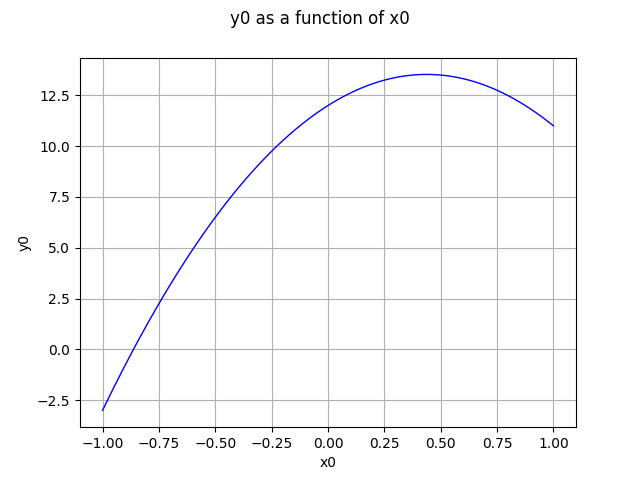

In [10]:
model.draw(-1,1)

## Calibration

In [11]:
outputObservationNoiseSigma = 2. # (Pa)
observationOutputNoise = ot.Normal(0.,outputObservationNoiseSigma)

In [30]:
size = 100
calibrationResult, inputSample, outputObservations = generateTheta(size, observationOutputNoise, candidate)

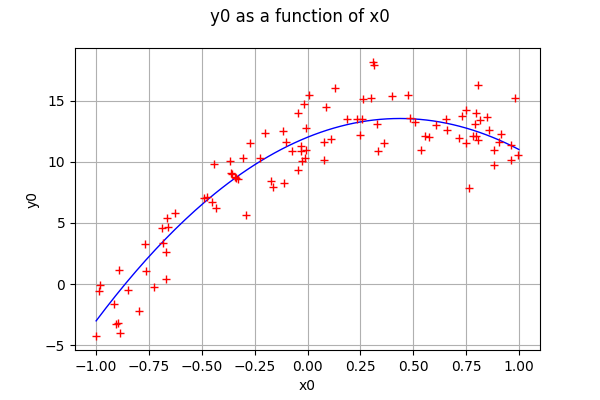

In [31]:
myGraph = model.draw(-1,1)
myCloud = ot.Cloud(inputSample[:,0],outputObservations)
myCloud.setColor("red")
myGraph.add(myCloud)
myGraph

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [32]:
thetaStar = calibrationResult.getParameterMAP()
thetaStar

class=Point name=Unnamed dimension=3 values=[12.1385,7.31658,-8.43426]

In [33]:
thetaPosterior = calibrationResult.getParameterPosterior()
thetaPosterior

class=Normal name=Normal dimension=3 mean=class=Point name=Unnamed dimension=3 values=[12.1385,7.31658,-8.43426] sigma=class=Point name=Unnamed dimension=3 values=[0.28965,0.331504,0.613191] correlationMatrix=class=CorrelationMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[1,0.0186273,-0.737945,0.0186273,1,-0.100556,-0.737945,-0.100556,1]

In [34]:
covarianceThetaStarOT = thetaPosterior.getCovariance()
covarianceThetaStarOT

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[0.0838971,0.00178859,-0.131067,0.00178859,0.109895,-0.0204404,-0.131067,-0.0204404,0.376003]

## Draw residual distribution

The goal is to check the distribution of the residuals.

In [35]:
residualDistribution = calibrationResult.getObservationsError()
residualDistribution

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1.94803] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

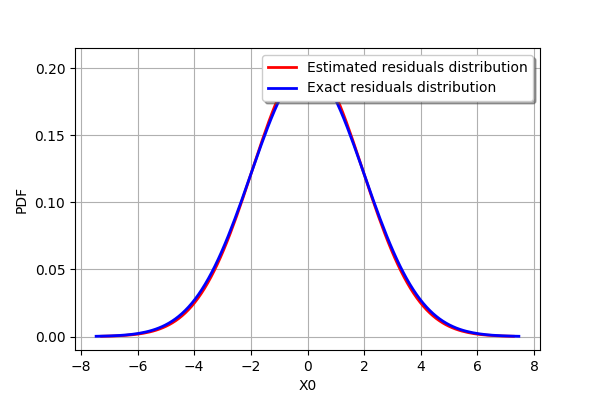

In [36]:
graph = residualDistribution.drawPDF()
graphExact = observationOutputNoise.drawPDF()
graphExact.setColors(["blue"])
graph.add(graphExact)
graph.setLegends(["Estimated residuals distribution","Exact residuals distribution"])
graph

## Create an empirical sample of theta

In [18]:
resampleSize = 500
sampleTheta = ot.Sample(resampleSize,parameterDimension)
sampleTheta.setDescription(descr)
for i in range(resampleSize):
    calibrationResult, inputSample, outputObservations = generateTheta(size, observationOutputNoise, candidate)
    thetaStar = calibrationResult.getParameterMAP()
    sampleTheta[i] = thetaStar

In [19]:
sampleTheta[0:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=3 description=[Theta1,Theta2,Theta3] data=[[11.5395,6.56604,-7.02032],[12.1247,6.84521,-7.22208],[12.4815,7.27391,-8.96506],[12.2815,6.98578,-9.3288],[11.9554,7.33211,-7.59092]]

## Draw distributions

In [20]:
import pylab as pl
import openturns.viewer as otv

Set the mean of the posterior distribution to the candidate, so that we can compare the variances.

In [21]:
thetaPosterior

class=Normal name=Normal dimension=3 mean=class=Point name=Unnamed dimension=3 values=[11.674,7.0549,-7.77793] sigma=class=Point name=Unnamed dimension=3 values=[0.341786,0.401568,0.754097] correlationMatrix=class=CorrelationMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[1,0.0542685,-0.738218,0.0542685,1,-0.20137,-0.738218,-0.20137,1]

In [22]:
Sigma = thetaPosterior.getCovariance()
Sigma

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[0.116817,0.00744835,-0.190268,0.00744835,0.161257,-0.0609791,-0.190268,-0.0609791,0.568663]

In [23]:
thetaPosteriorNormal = ot.Normal(candidate,Sigma)
thetaPosteriorNormal

class=Normal name=Normal dimension=3 mean=class=Point name=Unnamed dimension=3 values=[12,7,-8] sigma=class=Point name=Unnamed dimension=3 values=[0.341786,0.401568,0.754097] correlationMatrix=class=CorrelationMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[1,0.0542685,-0.738218,0.0542685,1,-0.20137,-0.738218,-0.20137,1]

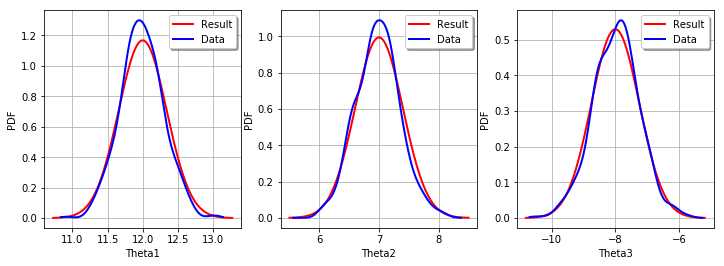

In [24]:
fig = pl.figure(figsize=(12, 4))
for i in range(parameterDimension):
    thetai = thetaPosteriorNormal.getMarginal(i)
    graph = thetai.drawPDF()
    graph.setXTitle(descr[i])
    # From data
    sampleMargin = sampleTheta.getMarginal(i)
    ksdist = ot.KernelSmoothing().build(sampleMargin).drawPDF()
    ksdist.setColors(["blue"])
    graph.add(ksdist)
    graph.setLegends(["Result","Data"])
    ax = fig.add_subplot(1, parameterDimension, i+1)
    _ = otv.View(graph, figure=fig, axes=[ax])